# Project 3: Web APIs & NLP (Part 3)

## Problem Statement

Our Social Media department has informed us that users of our newly created Beauty Insider Community Forum have been posting in the wrong group. 

The makeup and perfumes posts are posted in the General Discussion page and we need to find a way to classify their posts into Makeup and Perfumes categories for better analysis of their needs and interests.

We will be using Reddit posts from r/Makeup and r/Perfumes to create a text classifier model that can classify posts into the 2 categories with accuracy more than 50% (baseline accuracy). We can then use the model to classify the posts in our forum. Through this project, we will also find out the trending words in each subreddit to guide our marketing department.

In [33]:
import pandas as pd
import string
import re
import nltk
import numpy as np
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wujin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [77]:
# Import the dataset
makeup_perfumes = pd.read_csv('../data/makeup_perfumes.csv')
makeup_perfumes.dropna(inplace=True)
makeup_perfumes.isnull().sum()

subreddit                    0
title_selftext               0
word_count                   0
title_selftext_tokenized     0
title_selftext_nostop        0
title_selftext_lemmatized    0
dtype: int64

## Modelling

We will be looking at 3 models namely Bernoulli Naive Bayes, Logistic Regression and Random Forest Classifier while using Count vectorizer and TF-IDF vectorizer.
We will use GridSearchCV to determine the best parameters for each model.

In [76]:
makeup_perfumes['subreddit'].value_counts(normalize = True)

0    0.500803
1    0.499197
Name: subreddit, dtype: float64

Our baseline model accuracy is the probability that a given post will come from our target subreddit and since both subreddit posts are roughly equal, we are looking to create models that can score better than 50% in accuracy.

### Bernoulli Naive Bayes - Count Vectorizer

In [35]:
X = makeup_perfumes['title_selftext_lemmatized']
y = makeup_perfumes['subreddit']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify     = y)

In [37]:
# Set up a pipeline with count vectorizer and tf-idf vectorizer 

cvec_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [39]:
def NLP_model(vect, vectorizer, mod, model, vect_params, n):
    
    pipe = Pipeline([
    (vect, vectorizer),
    (mod, model)
])
    gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=vect_params, # what parameters values are we searching?
                  cv=n) 
    
    gs.fit(X_train, y_train)
    
    # What's the best parameters?
    
    print('Best fitting parameters:', gs.best_params_)

    # What's the best score?
    print('Grid Search Best Score:', round(gs.best_score_, 5))
    
    # Score model on training set.
    print('Train Accuracy:', round(gs.score(X_train, y_train), 5))
    
    # Score model on testing set.
    print('Test Accuracy:', round(gs.score(X_test, y_test),5))
    
    # Get predictions
    preds = gs.predict(X_test)
    
    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    # View confusion matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
    
    # Calculate the specificity

    spec = tn / (tn + fp)

    print('Specificity:', round(spec, 5))
    
    # Calculate the precision
    
    precision = tp / (tp + fp)
    
    print('Precision:', round(precision, 5))
    
    # Calculate the sensitivity
    
    sensitivity = tp / (tp + fn)
    
    print('Sensitivity:', round(sensitivity, 5))
    
    # Calculate F1 score
    
    f1 = f1_score(y_test, preds)
    
    print('F1 score:', round(f1, 5))
    
    # Calculate ROC_AUC score
    
    ROC_AUC = roc_auc_score(y_test, preds)
    
    print('ROC AUC score:', round(ROC_AUC, 5))
    
    print('TN:', tn)
    print('FP:', fp)
    print('FN:', fn)
    print('TP:', tp)
    
    # Save results to Dataframe
    df = pd.DataFrame()
    df['model_vec'] = [f'{mod}_{vect}']
    df['grid_search_best_score'] = round(gs.best_score_, 5)
    df['train_accuracy'] = round(gs.score(X_train, y_train), 5)
    df['test_accuracy'] = round(gs.score(X_test, y_test), 5)
    df['sensitivity'] =  round((tp / (tp + fn)), 5)
    df['specificity'] = round((tn / (tn + fp)), 5)
    df['precision'] = round((tp / (tp + fp)), 5)
    df['f1_score'] = round(f1_score(y_test, preds), 5)
    df['roc_auc_score'] = round(roc_auc_score(y_test, preds), 5)
    df['tn'] = tn
    df['fp'] = fp
    df['fn'] = fn
    df['tp'] = tp
    
    return df

In [60]:
# Define list of DataFrames to save all best model outputs
df_all = []

### Bernoulli Naive Bayes - Count Vectorizer

Best fitting parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}
Grid Search Best Score: 0.8863
Train Accuracy: 0.89112
Test Accuracy: 0.89085


C:\Users\wujin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Specificity: 0.79407
Precision: 0.82705
Sensitivity: 0.98794
F1 score: 0.90037
ROC AUC score: 0.89101
TN: 991
FP: 257
FN: 15
TP: 1229


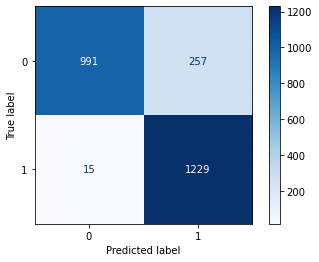

In [42]:
bernnb_cvec = NLP_model('cvec', CountVectorizer(), 'bernnb', BernoulliNB(), cvec_params, 5)

In [61]:
df_all.append(bernnb_cvec)

### Bernoulli Naive Bayes -  TF-IDF Vectorizer

Best fitting parameters: {'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}
Grid Search Best Score: 0.8863
Train Accuracy: 0.89112
Test Accuracy: 0.89085


C:\Users\wujin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Specificity: 0.79407
Precision: 0.82705
Sensitivity: 0.98794
F1 score: 0.90037
ROC AUC score: 0.89101
TN: 991
FP: 257
FN: 15
TP: 1229


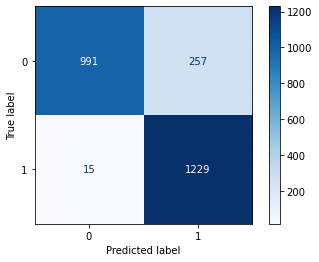

In [43]:
bernnb_tvec = NLP_model('tvec', TfidfVectorizer(), 'bernnb', BernoulliNB(), tvec_params, 5)

In [62]:
df_all.append(bernnb_tvec)

### Logistic Regression - Count Vectorizer

Best fitting parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}
Grid Search Best Score: 0.937
Train Accuracy: 0.97806
Test Accuracy: 0.94823
Specificity: 0.92147
Precision: 0.92525
Sensitivity: 0.97508
F1 score: 0.94951
ROC AUC score: 0.94828
TN: 1150
FP: 98
FN: 31
TP: 1213


C:\Users\wujin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


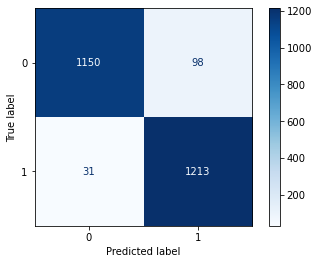

In [65]:
lr_cvec = NLP_model('cvec', CountVectorizer(), 'lr', LogisticRegression(), cvec_params, 5)

In [66]:
df_all.append(lr_cvec)

### Logistic Regression -  TF-IDF Vectorizer

Best fitting parameters: {'tvec__max_df': 0.9, 'tvec__max_features': 3000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}
Grid Search Best Score: 0.94168
Train Accuracy: 0.96134
Test Accuracy: 0.94904


C:\Users\wujin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Specificity: 0.92388
Precision: 0.92731
Sensitivity: 0.97428
F1 score: 0.95022
ROC AUC score: 0.94908
TN: 1153
FP: 95
FN: 32
TP: 1212


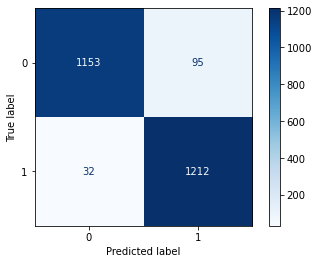

In [67]:
lr_tvec = NLP_model('tvec', TfidfVectorizer(), 'lr', LogisticRegression(), tvec_params, 5)

In [68]:
df_all.append(lr_tvec)

### Random Forest - Count Vectorizer

Best fitting parameters: {'cvec__max_df': 0.95, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}
Grid Search Best Score: 0.93379
Train Accuracy: 0.99438
Test Accuracy: 0.93419


C:\Users\wujin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Specificity: 0.94952
Precision: 0.94776
Sensitivity: 0.91881
F1 score: 0.93306
ROC AUC score: 0.93416
TN: 1185
FP: 63
FN: 101
TP: 1143


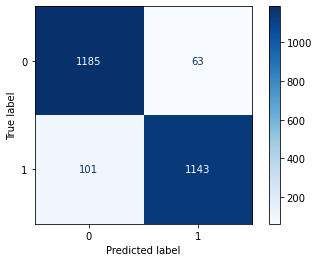

In [69]:
rf_cvec = NLP_model('cvec', CountVectorizer(), 'rf', RandomForestClassifier(), cvec_params, 5)

In [70]:
df_all.append(rf_cvec)

### Random Forest - TF-IDF Vectorizer

Best fitting parameters: {'tvec__max_df': 0.95, 'tvec__max_features': 5000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1)}
Grid Search Best Score: 0.93472
Train Accuracy: 0.99465
Test Accuracy: 0.9382


C:\Users\wujin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Specificity: 0.95112
Precision: 0.94967
Sensitivity: 0.92524
F1 score: 0.9373
ROC AUC score: 0.93818
TN: 1187
FP: 61
FN: 93
TP: 1151


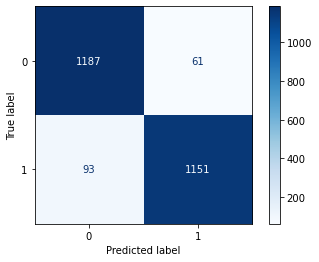

In [71]:
rf_tvec = NLP_model('tvec', TfidfVectorizer(), 'rf', RandomForestClassifier(), tvec_params, 5)

In [72]:
df_all.append(rf_tvec)

In [73]:
full_df = pd.concat(df_all)

In [74]:
pd.set_option('display.max_colwidth', None)
full_df.sort_values(by=['test_accuracy'], ascending=False).reset_index(drop=True)

,model_vec,grid_search_best_score,train_accuracy,test_accuracy,sensitivity,specificity,precision,f1_score,roc_auc_score,tn,fp,fn,tp
0,lr_tvec,0.94168,0.96134,0.94904,0.97428,0.92388,0.92731,0.95022,0.94908,1153,95,32,1212
1,lr_cvec,0.93700,0.97806,0.94823,0.97508,0.92147,0.92525,0.94951,0.94828,1150,98,31,1213
2,rf_tvec,0.93472,0.99465,0.93820,0.92524,0.95112,0.94967,0.93730,0.93818,1187,61,93,1151
3,rf_cvec,0.93379,0.99438,0.93419,0.91881,0.94952,0.94776,0.93306,0.93416,1185,63,101,1143
4,bernnb_cvec,0.88630,0.89112,0.89085,0.98794,0.79407,0.82705,0.90037,0.89101,991,257,15,1229
5,bernnb_tvec,0.88630,0.89112,0.89085,0.98794,0.79407,0.82705,0.90037,0.89101,991,257,15,1229


Logistic regression model with TF-IDF Vectorizer has the highest test accuracy of 0.94904. It scores well (>0.9) for all other scoring metrics so we can adopt this model for predicting the subreddit which the posts belong to.

## Limitations and Future Plans

We see some difference between the train and test scores and we can train more data to prevent overfitting of our model.

To further improve the accuracy of our model, we would want to try including more stop words to make our analysis more relevant. We can also try more advanced modelling techniques like XGBoost, CatBoost and do further tuning of hyperparameters to improve the performance of our model. We can see if combining different models can lead to improvements to our model's performance metrics.

Further sentiment analysis can be done on the posts to understand brand and product sentiments for better targetted marketing efforts.

## Conclusion

After comparing with the other models, we have concluded that the Logistic Regression model with TF-IDF Vectorizer has the highest test accuracy of 0.94904. 

We are confident that this model can be deployed for the classification of our forum's posts into either Makeup or Perfumes categories to a high accuracy level.

We have also identified some words and bigrams that appear most frequently in Makeup and Perfumes subreddits that consists of brands, products and product features that can be useful for analysing and understanding customers' preferences.